In [19]:
import numpy as np
import rebound
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerBase
MEarth = 5.97e24
REarth = 6378.135e3

In [20]:
visor,magC,adu,npix,bkgnd,streak,rate = np.genfromtxt("mags-streaks.dat",usecols=(1,2,3,4,5,6,7),unpack=True)
gmag = -2.5*np.log10(adu - npix*bkgnd) + magC -2.5 * np.log10(30* rate/streak)

In [21]:
constellations = {
    "Starlink2": [ {'NPLANES':32,'SATPP':50,'INC':53,'ALT':550},
        {'NPLANES':72,'SATPP':22,'INC':53.2,'ALT':540},
        {'NPLANES':36,'SATPP':20,'INC':70,'ALT':570},
        {'NPLANES':6,'SATPP':58,'INC':97.6,'ALT':560},
        {'NPLANES':4,'SATPP':43,'INC':97.6,'ALT':560.1},],
    }


def add_to_simulation(sim, ICs, debug=False):
    for IC in ICs:
        nplanes=IC['NPLANES']
        nsat=IC['SATPP']
        a = IC['ALT']*1000.+REarth

        Omegas = np.linspace(0.,2.*np.pi,nplanes)
        for i, Omega in enumerate(Omegas):
            # 5 percent jitter
            Ms = np.linspace(0.,2.*np.pi,nsat)+ 2.*np.pi/nsat*0.25*np.random.normal(size=nsat)
            for j, M in enumerate(Ms):
                sim.add(M=M, a=a, omega=0, e=0, Omega=Omega, inc=IC['INC']*np.pi/180.)
                if debug and sim.N>100:
                    return
def rotY(xyz,alpha):
    c, s = np.cos(alpha), np.sin(alpha)
    M = np.array([[c,0,-s],[0,1,0],[s,0,c]])
    return xyz @ M
def rotZ(xyz,alpha):
    c, s = np.cos(alpha), np.sin(alpha)
    M = np.array([[c,-s,0],[s,c,0],[0,0,1]])
    return xyz @ M
def length_of_night(timeOfYear,latitude, p=0):
    # https://www.ikhebeenvraag.be/mediastorage/FSDocument/171/Forsythe+-+A+model+comparison+for+daylength+as+a+function+of+latitude+and+day+of+year+-+1995.pdf
    # p=18 for astronomical twilight
    theta = 2.*np.arctan(0.9671396*np.tan(-timeOfYear/2.+np.pi/4.))
    phi = np.arcsin(0.39795*np.cos(theta))
    return 24./np.pi * np.arccos((np.sin(p*np.pi/180.)+np.sin(latitude*np.pi/180.)*np.sin(phi))/(np.cos(latitude*np.pi/180.)*np.cos(phi)))

def get_stereographic_data(sims, latitude, month, hour, albedo, area):
    # latitude in degrees
    # month in months from spring euquinox
    # hours in hours since midnight
    latitude = latitude/180.*np.pi 
    tilt = 23.4*np.sin(month/6.*np.pi)/180.*np.pi
    hour = hour/12.*np.pi
    xy, mag = [], []     
    for name in sims:
        sim = sims[name]
        sun = np.array([-1.4959787e+11,0,0]) # in m
        sun = rotY(sun, tilt)
        sun_n = sun/np.linalg.norm(sun)

        obs = np.array([REarth, 0, 0])
        obs = rotY(obs, -latitude)
        obs = rotZ(obs, hour)
        obs_n = obs/np.linalg.norm(obs)

        xyz = np.zeros((sim.N,3),dtype="float64")
        sim.serialize_particle_data(xyz=xyz)
        xyz = xyz[1:] # remove earth


        lit = np.linalg.norm(np.cross(xyz,sun_n),axis=1)>REarth

        xyz = xyz[lit]

        xyz_n = xyz/np.linalg.norm(xyz,axis=1)[:,np.newaxis]
        xyz_r = xyz - obs
        xyz_rd = np.linalg.norm(xyz_r,axis=1)
        xyz_rn = xyz_r/xyz_rd[:,np.newaxis]

        phase = np.arccos(np.clip(np.dot(xyz_rn, -sun_n), -1.0, 1.0)) # assume sun is in -x direction

        fac1 = 2/(3*np.pi**2)
        magV = -26.44 -2.5*np.log10(fac1 * area * albedo * ( (np.pi-phase)*np.cos(phase) + np.sin(phase) ) ) + 5 * np.log10(xyz_rd)


        elevation = (np.pi/2.-np.arccos(np.dot(xyz_rn,obs_n)))/np.pi*180.

        xyz = rotZ(xyz, -hour)
        xyz = rotY(xyz, latitude)
        xyz_r = xyz - np.array([REarth, 0, 0])
        xyz_rd = np.linalg.norm(xyz_r,axis=1)
        xyz_rn = xyz_r/xyz_rd[:,np.newaxis]

        elevation_cut = 0
        xyz_rn = xyz_rn[elevation>elevation_cut]
        magV = magV[elevation>elevation_cut]

        xy.append(xyz_rn[:,1:3]/(1.+xyz_rn[:,0,np.newaxis]))
        mag.append(magV)
    if len(xy)>0:
        return np.concatenate(xy), np.concatenate(mag) 
    else:
        return None, None


def get_simulations(add_constellations=None, use_cache=True):
    if add_constellations is None:
        add_constellations = constellations.keys() # all constellations
    sims = {}
    for c in add_constellations:
        print(c)
        if c not in constellations:
            raise RuntimeError("Constellation %s not found."%c)
        sim = None
        if use_cache:
            filename = "mega_"+"".join(x for x in c if x.isalnum())+".bin"
            try:
                sim = rebound.Simulation(filename)
            except:
                # need to create simulation
                pass
        if sim is None:
            sim = rebound.Simulation()
            sim.G = 6.67430e-11
            sim.add(m=MEarth)
            sim.N_active = 1
            add_to_simulation(sim, constellations[c])
            if use_cache:
                sim.save(filename)
        sims[c] = sim
    return sims
sims = get_simulations(add_constellations=['Starlink2'])

Starlink2


In [22]:
#def generate_fig(filename=None, latitude=50., months=[-3,0,3], hours=[-3,0,3]): 
def generate_fig(filename=None, latitude=0): 
    # latitude in degrees
    # months since spring equinox
    # hours since midnight
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)
    hour=-1.5
    month=3.7
    albedo=0.3
    area=4
    xy, mag = get_stereographic_data(sims, latitude=latitude, month=month, hour=hour, albedo=albedo, area=area)
    xyall=xy
    magall=mag
    for hour in np.arange(-1.25,1.6,0.25):
        xy1, mag1 = get_stereographic_data(sims, latitude=latitude, month=month, hour=hour, albedo=albedo, area=area)
        xy=np.append(xy,xy1,axis=0)
        mag=np.append(mag,mag1,axis=0)
    mag+=np.random.normal(0.,0.2,size=len(mag))
    xy2=xy[xy[:,1]<0]
    xy3=np.sqrt(xy2[:,1]**2.+xy2[:,0]**2.)
    xy4=xy2[xy3<np.pi/4.]
    mag2=mag[xy[:,1]<0]
    mag4=mag2[xy3<np.pi/4.]

    gmagbins = np.linspace(1,10,10)
    ax.set_xlabel(r"$m_{g'}$",fontsize=16)
    ax.set_ylabel("Satellites per Bin (model)",fontsize=16)
    magbins = np.linspace(1,10,30)
    ax.set_xlim([3,9])
    ax.set_ylim([0,30])

    n, bins, patches = ax.hist(mag4,bins=magbins,histtype='stepfilled',color="#A4A4A4",lw=3,zorder=-10)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    
    ax2 = ax.twinx()
    ax2.hist(gmag,bins=gmagbins,histtype="step",edgecolor="b",hatch='\\',lw=0.5)
    ax2.text(7.2,7.5,'modelled',c='#A4A4A4',fontsize=14)
    ax2.text(7.2,7.1,'observed-Starlink',c='b',fontsize=14)
    ax2.text(9.3,3.5,"Satellites per Bin (observed)",fontsize=16,verticalalignment='center',rotation=-90)
    plt.ylim(0,8)
            

    if filename is not None:
        plt.savefig(filename,facecolor='white', transparent=False,dpi=200)
        plt.close(fig)
    

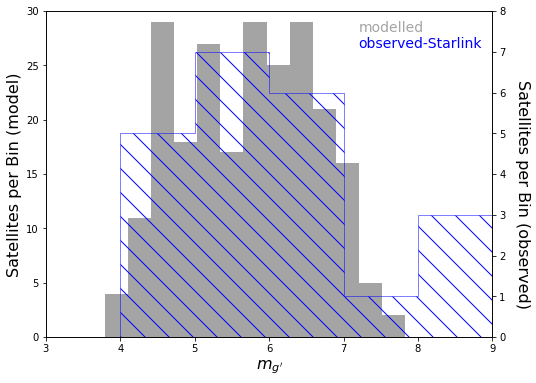

In [23]:
generate_fig(latitude=48.5)

In [24]:
generate_fig("hist_lamb.png", latitude=48.5)